In [1]:
# Copyright (c) 2017 Ben Poole & Friedemann Zenke
# MIT License -- see LICENSE for details
# 
# This file is part of the code to reproduce the core results of:
# Zenke, F., Poole, B., and Ganguli, S. (2017). Continual Learning Through
# Synaptic Intelligence. In Proceedings of the 34th International Conference on
# Machine Learning, D. Precup, and Y.W. Teh, eds. (International Convention
# Centre, Sydney, Australia: PMLR), pp. 3987–3995.
# http://proceedings.mlr.press/v70/zenke17a.html

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import tensorflow as tf
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

import sys, os
sys.path.extend([os.path.expanduser('..')])
from pathint import utils
import seaborn as sns
sns.set_style("ticks")

from tqdm import trange, tqdm

# import operator
import matplotlib.colors as colors
import matplotlib.cm as cmx

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


## Parameters

In [2]:
select = tf.select if hasattr(tf, 'select') else tf.where

In [3]:
# Data params
input_dim = 784
output_dim = 10

# Network params
n_hidden_units = 50
activation_fn = tf.nn.relu

# Optimization params
batch_size = 1000
epochs_per_task = 5

n_stats = 1

# Reset optimizer after each age
reset_optimizer = True

## Construct datasets

In [4]:
task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9], [4,6],[8,1],[0,3],[2,4],[5,7]]
#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9], [4,6],[8,1],[0,3],[2,9],[5,7]]
# task_labels = [[0,1,2,3,4], [5,6,7,8,9]]
n_tasks = len(task_labels)
training_datasets = utils.construct_split_mnist(task_labels, split='train')
validation_datasets = utils.construct_split_mnist(task_labels, split='test')
# training_datasets = utils.mk_training_validation_splits(full_datasets, split_fractions=(0.9, 0.1))

## Construct network, loss, and updates

In [5]:
tf.reset_default_graph()

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

In [7]:
# tf.equal(output_mask[None, :], 1.0)

In [8]:
import keras.backend as K
import keras.activations as activations

output_mask = tf.Variable(tf.zeros(output_dim), name="mask", trainable=False)

def masked_softmax(logits):
    # logits are [batch_size, output_dim]
    x = select(tf.tile(tf.equal(output_mask[None, :], 1.0), [tf.shape(logits)[0], 1]), logits, -1e32 * tf.ones_like(logits))
    return activations.softmax(x)

def set_active_outputs(labels):
    new_mask = np.zeros(output_dim)
    for l in labels:
        new_mask[l] = 1.0
    sess.run(output_mask.assign(new_mask))
    #print(sess.run(output_mask))
    
def masked_predict(model, data, targets):
    pred = model.predict(data)
    #print(pred)
    acc = np.argmax(pred,1)==np.argmax(targets,1)
    return acc.mean()

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
from keras.models import Sequential
from keras.layers import Dense

from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
def custom_activation(x):
    A=K.relu(x)
    return(K.log(1+A))
get_custom_objects().update({'custom_activation':Activation(custom_activation)})

model = Sequential()
model.add(Dense(n_hidden_units, activation=activation_fn, input_shape=(input_dim,)))
#model.add(Dense(n_hidden_units, activation=activation_fn))
model.add(Dense(output_dim, kernel_initializer='zero', activation=masked_softmax))
#model.add(Dense(output_dim, activation=masked_softmax, input_shape=(input_dim,)))

In [10]:
from pathint import protocols
from pathint.optimizers import KOOptimizer
from keras.optimizers import Adam, RMSprop,SGD
from keras.callbacks import Callback
from pathint.keras_utils import LossHistory
from keras.callbacks import History 
from keras.callbacks import LambdaCallback

#protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
#protocol_name, protocol = protocols.FISHER_PROTOCOL('sum')
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
# opt = SGD(1e-3)
# opt = RMSprop(lr=1e-3)
oopt = KOOptimizer(opt, model=model, compute_fisher=False, **protocol)
model.compile(loss='categorical_crossentropy', optimizer=oopt, metrics=['accuracy'])
model.model._make_train_function()
saved_weights = model.get_weights()

save_weights_epoch=[]
save_loss_epoch=[]
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: save_weights_epoch.append(model.get_weights()))
history = LossHistory()
callbacks = [history]
datafile_name = "split_mnist_data_%s.pkl.gz"%protocol_name

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


## Train!

In [11]:
def run_fits(cvals, training_data, valid_data, eval_on_train_set=False, nstats=1):
    acc_mean = dict()
    acc_std = dict()
    model_weights_save = []   #Empty list to save the model weights aftertraining each task
    for cidx, cval_ in enumerate(tqdm(cvals)):
        runs = []
        for runid in range(nstats):
            sess.run(tf.global_variables_initializer())
            # model.set_weights(saved_weights)
            cstuffs = []
            evals = []
            print("setting cval")
            cval = cval_
            oopt.set_strength(cval)
            oopt.init_task_vars()
            print("cval is", sess.run(oopt.lam))
            for age, tidx in enumerate(range(n_tasks)):
                print("Age %i, cval is=%f"%(age,cval))
                print("settint output mask")
                set_active_outputs(task_labels[age])
                stuffs = model.fit(training_data[tidx][0], training_data[tidx][1], batch_size, epochs_per_task, callbacks=[history,print_weights])
                oopt.update_task_metrics(training_data[tidx][0], training_data[tidx][1], batch_size)
                oopt.update_task_vars()
                ftask = []
                model_weights_save.append(model.get_weights()) #Save the model weights aftertraining each task
                for j in range(n_tasks):
                    set_active_outputs(task_labels[j])
                    if eval_on_train_set:
                        f_ = masked_predict(model, training_data[j][0], training_data[j][1])
                    else:
                        f_ = masked_predict(model, valid_data[j][0], valid_data[j][1])
                    ftask.append(np.mean(f_))
                evals.append(ftask)
                cstuffs.append(stuffs)

                # Re-initialize optimizater variables
                if reset_optimizer:
                    oopt.reset_optimizer()

            evals = np.array(evals)
            runs.append(evals)
        
        runs = np.array(runs)
        acc_mean[cval_] = runs.mean(0)
        acc_std[cval_] = runs.std(0)
    return dict(mean=acc_mean, std=acc_std),model_weights_save,cstuffs

In [12]:
# cvals = np.concatenate(([0], np.logspace(-2, 2, 10)))
# cvals = np.concatenate(([0], np.logspace(-1, 2, 2)))
# cvals = np.concatenate(([0], np.logspace(-2, 0, 3)))
cvals = np.logspace(-3, 3, 7)#[0, 1.0, 2, 5, 10]
cvals = [1.0]
print(cvals)

[1.0]


In [13]:
#%%capture
recompute_data = True
if recompute_data:
    data,model_weights_save,cstuffs = run_fits(cvals, training_datasets, validation_datasets, eval_on_train_set=False, nstats=n_stats)
    utils.save_zipped_pickle(data, datafile_name)

  0%|          | 0/1 [00:00<?, ?it/s]

setting cval
cval is 1.0
Age 0, cval is=1.000000
settint output mask
Epoch 1/5
12665/12665 [==============================] - 0s - loss: 0.6223 - acc: 0.9195     
Epoch 2/5
12665/12665 [==============================] - 0s - loss: 0.2870 - acc: 0.9876     
Epoch 3/5
12665/12665 [==============================] - 0s - loss: 0.0779 - acc: 0.9949     
Epoch 4/5
12665/12665 [==============================] - 0s - loss: 0.0270 - acc: 0.9962     
Epoch 5/5
12665/12665 [==============================] - 0s - loss: 0.0155 - acc: 0.9976     
Age 1, cval is=1.000000
settint output mask
Epoch 1/5
12089/12089 [==============================] - 0s - loss: 0.6282 - acc: 0.6638     
Epoch 2/5
12089/12089 [==============================] - 0s - loss: 0.2601 - acc: 0.9273     
Epoch 3/5
12089/12089 [==============================] - 0s - loss: 0.1294 - acc: 0.9581     
Epoch 4/5
12089/12089 [==============================] - 0s - loss: 0.1113 - acc: 0.9665     
Epoch 5/5
12089/12089 [==================

100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


In [14]:
#Inspection of behavior of importance parameter big_omega after every task 
from numpy import count_nonzero
last_epoch_batchindex = []
counter = 0
for i,j in enumerate(history.batchindex):
    try:
        if history.batchindex[i+1] > j:
            pass
        else:
            counter = counter+1
            if counter%epochs_per_task == 0:
                last_epoch_batchindex.append(i)
    except:
        last_epoch_batchindex.append(i)

print('Batch-id for last epoch of each task:',last_epoch_batchindex)
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    key = list(history.big_omega[epoch_id].keys())
    print('Parameter importance (big_omega) for task {0} shape is '.format(i), [history.big_omega[epoch_id][ke].shape for ke in key]) 

non_zero_imp_param = []
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    key = list(history.big_omega[epoch_id].keys())
    non_zero_imp_param.append(sum([count_nonzero(history.big_omega[epoch_id][ke]) for ke in key]))
    print('Number of non-zero elements of importance (big_omega) for task {0} is '.format(i),non_zero_imp_param[i])

Batch-id for last epoch of each task: [64, 129, 189, 254, 314]
*----------------------------*
Parameter importance (big_omega) for task 0 shape is  [(784, 50), (50,), (50, 10), (10,)]
Parameter importance (big_omega) for task 1 shape is  [(784, 50), (50,), (50, 10), (10,)]
Parameter importance (big_omega) for task 2 shape is  [(784, 50), (50,), (50, 10), (10,)]
Parameter importance (big_omega) for task 3 shape is  [(784, 50), (50,), (50, 10), (10,)]
Parameter importance (big_omega) for task 4 shape is  [(784, 50), (50,), (50, 10), (10,)]
*----------------------------*
Number of non-zero elements of importance (big_omega) for task 0 is  0
Number of non-zero elements of importance (big_omega) for task 1 is  30358
Number of non-zero elements of importance (big_omega) for task 2 is  33475
Number of non-zero elements of importance (big_omega) for task 3 is  34308
Number of non-zero elements of importance (big_omega) for task 4 is  36046


In [15]:
#Inspection of losses after every task 
loss_after_task=[]
print('Batch-id for last epoch of each task:',last_epoch_batchindex)
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    loss_after_task.append(history.losses[epoch_id])
    print('Loss after task {0} '.format(i), history.losses[epoch_id]) 
print('*----------------------------*')

#Inspection of surrogate loss or regularization (sum(big_omega x (theta'-theta))) after every task 
surrogate_loss_after_task=[]
for i,epoch_id in enumerate(last_epoch_batchindex):
    surrogate_loss_after_task.append(history.regs[epoch_id])
    print('Surrogate loss after task {0} '.format(i), history.regs[epoch_id]) 

Batch-id for last epoch of each task: [64, 129, 189, 254, 314]
*----------------------------*
Loss after task 0  0.0076191244
Loss after task 1  0.11848289
Loss after task 2  0.078376904
Loss after task 3  0.03899736
Loss after task 4  0.12583107
*----------------------------*
Surrogate loss after task 0  0.0
Surrogate loss after task 1  0.033871766
Surrogate loss after task 2  0.061868932
Surrogate loss after task 3  0.038659338
Surrogate loss after task 4  0.029494783


In [16]:
data = utils.load_zipped_pickle(datafile_name)
print(cvals)

[1.0]


In [17]:
print(model.summary())
'''
print(data['mean'],model.summary())
for k in cvals:
    for i in range(n_tasks):
        for j in range(i):
            data['mean'][k][j][i] = 0
            data['std'][k][j][i] = 0
'''

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                39250     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
None


"\nprint(data['mean'],model.summary())\nfor k in cvals:\n    for i in range(n_tasks):\n        for j in range(i):\n            data['mean'][k][j][i] = 0\n            data['std'][k][j][i] = 0\n"

In [18]:
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=-5, vmax=np.log(np.max(list(data['mean'].keys()))))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
print(scalarMap.get_clim())

(-5.0, 0.0)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


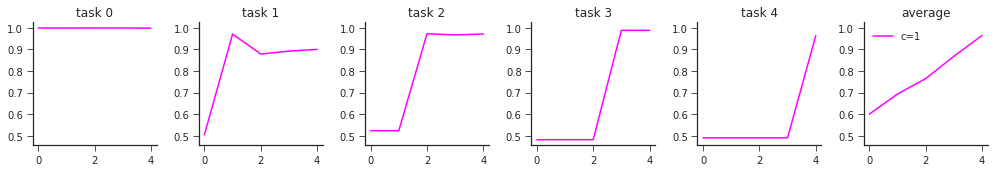

In [19]:
import pdb
figure(figsize=(14, 2.5))
axs = [subplot(1,n_tasks+1,1)]#, None, None]

for i in range(1, n_tasks + 1):
    axs.append(subplot(1, n_tasks+1, i+1, sharex=axs[0], sharey=axs[0]))
    
keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        colorVal = scalarMap.to_rgba(np.log(cval))
        # axs[j].plot(evals[:, j], c=colorVal)
        axs[j].errorbar(range(n_tasks), mean_vals[:, j], yerr=std_vals[:, j]/np.sqrt(n_stats), c=colorVal)
    label = "c=%g"%cval
    average = mean_vals.mean(1)
    axs[-1].plot(average, c=colorVal, label=label)
    
for i, ax in enumerate(axs):
    ax.legend(loc='best')
    ax.set_title((['task %d'%j for j in range(n_tasks)] + ['average'])[i])
gcf().tight_layout()
sns.despine()
plt.savefig('MNIST_Accuracy_10task.pdf')

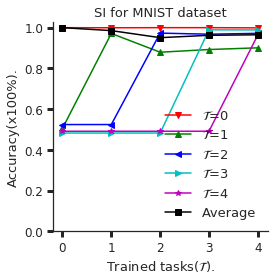

In [20]:
import pdb
figure(figsize=(4, 4))
axs = [subplot(1,1,1)]#, None, None]
fontsize = 13

keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

colorVal = ['r','g','b','c','m','k','y']
marker=["v","^","<",">","*","s"]

mean_stuff=[]
std_stuff=[]
for i in range(len(data['mean'][cval])):
    mean_stuff.append(data['mean'][cval][i][:i+1].mean())
    std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        label = "$\mathcal{T}$=%g"%j
        axs[0].plot(range(n_tasks), mean_vals[:, j], marker=marker[j], c=colorVal[j], label=label)
    axs[0].plot(range(n_tasks), mean_stuff, marker=marker[j+1], c=colorVal[j+1], label='Average')
    axs[0].legend(loc='best',prop={'size': fontsize})
    axs[0].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
    axs[0].set_ylabel('Accuracy(x100%).',fontsize=fontsize)
    axs[0].set_xticks(range(n_tasks))
    axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axs[0].tick_params(labelsize='large', width=3)
    axs[0].set_title('SI for MNIST dataset', fontsize=fontsize)

gcf().tight_layout()
sns.despine()
plt.savefig('MNIST_SI.pdf')

In [21]:
Flatten_weights=[]
#Flattening the weights into a list
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
for i in range(len(model_weights_save)):
    if i == 0:
        Flatten_weights.append(list(flatten(save_weights_epoch[epochs_per_task-2])))
        Flatten_weights.append(list(flatten(save_weights_epoch[epochs_per_task-1])))
    Flatten_weights.append(list(flatten(model_weights_save[i]))) 

Extract_model_params = []
for i in range(len(Flatten_weights)):   
    Extract_model_params.append(Flatten_weights[i])
    
gradient_save=[]
for i in range(1,len(Extract_model_params)):
    if i == 2:
        pass
    else :
        temp=list(np.asarray(Extract_model_params[i])-np.asarray(Extract_model_params[i-1]))
        gradient = [j/0.001 for j in temp]
        gradient_save.append(gradient)

In [23]:
len(gradient_save[0])

39760

In [26]:
#Creating the Hessian matrix diagonal emlements rom the gradients and finding rank by counting 
#non-zero diagonal elements
import math
Hessian_diagonal = []
Rank_Hessian_matrix = []
for k in range(len(gradient_save)):
    Hessian_diagonal = [elem*elem for elem in gradient_save[k]]
    rank_Hessian_matrix = count_nonzero(np.diag(np.asarray(Hessian_diagonal)))
    Rank_Hessian_matrix.append(rank_Hessian_matrix)
    print('Rank of the Hessian Matrix after task=',k,'is :',rank_Hessian_matrix)
    
rank_Hessian_matrix = []
for i,val in enumerate(Rank_Hessian_matrix):
    if i == 0 or val > rank_Hessian_matrix[i-1]:
        rank_Hessian_matrix.append(val)
    else:
        curr_task_rank  = rank_Hessian_matrix[i-1] + (rank_Hessian_matrix[i-1] - val) 
        if curr_task_rank < 39760:
            rank_Hessian_matrix.append(curr_task_rank)
        else:
            rank_Hessian_matrix.append(39760)
print(rank_Hessian_matrix)

Rank of the Hessian Matrix after task= 0 is : 30316
Rank of the Hessian Matrix after task= 1 is : 32689
Rank of the Hessian Matrix after task= 2 is : 31226
Rank of the Hessian Matrix after task= 3 is : 34237
Rank of the Hessian Matrix after task= 4 is : 30093
[30316, 32689, 34152, 34237, 38381]


/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:330: UserWarning: tight_layout not applied: number of rows in subplot specifications mustbe multiples of one another.
  warnings.warn('tight_layout not applied: '


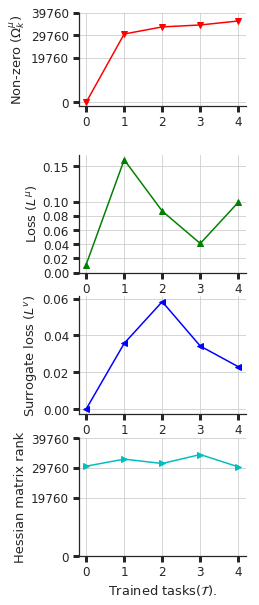

In [28]:
import pdb
figure(figsize=(3, 10))
axs = [subplot(5,1,1)]#, None, None]
for i in range(1, 4):
    axs.append(subplot(4, 1, i+1, sharex=axs[0]))
fontsize = 13

colorVal = ['r','g','b','c','m','k','y']
marker=["v","^","<",">","*","s"]

plots = [non_zero_imp_param,loss_after_task,surrogate_loss_after_task,Rank_Hessian_matrix]
ylabel = ['Non-zero ($\Omega_k^\mu$)', 'Loss ($L^\mu$)', 'Surrogate loss ($L^v$)','Hessian matrix rank']
ytick = [[0, 19760, 29760, 39760], [0,0.02,0.04,0.06,0.08,0.1, 0.15],[0,0.02,0.04,0.06], [0, 19760, 29760, 39760]]
title = ['Number of non-zero importance.', 'Loss', 'Surrogate loss', 'Hessian rank']
for i in range(4):
    axs[i].plot(range(n_tasks), plots[i], marker=marker[i], c=colorVal[i])
    axs[i].set_ylabel(ylabel[i],fontsize=fontsize)
    axs[i].set_yticks(ytick[i])
    axs[i].tick_params(labelsize='large', width=3)
    axs[i].grid()
axs[-1].set_xticks(range(n_tasks))
axs[-1].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
plt.tight_layout()
sns.despine()
plt.savefig('MNIST_SI_modeleval.pdf',bbox_inches = "tight")

--------------Euclidean distance--------------------
Between task 0 and 1 : 5.636150424450014
Between task 1 and 2 : 4.341738218024271


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """


Between task 2 and 3 : 4.779065465469706
Between task 3 and 4 : 1.8476188672604086
--------------Cosine distance--------------------


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


Between task 0 and 1 : 0.891
Between task 1 and 2 : 0.941
Between task 2 and 3 : 0.94
Between task 3 and 4 : 0.991
--------------Jaccard similarity--------------------
Between task 0 and 1 : 0.09417320647267172
Between task 1 and 2 : 0.1187461045951612
Between task 2 and 3 : 0.07458068718449763
Between task 3 and 4 : 0.1390144179040241
--------------Sequence Matcher--------------------
Between task 0 and 1 : 0.1778420523138833
Between task 1 and 2 : 0.21569416498993962
Between task 2 and 3 : 0.1402665995975855
Between task 3 and 4 : 0.24333501006036218


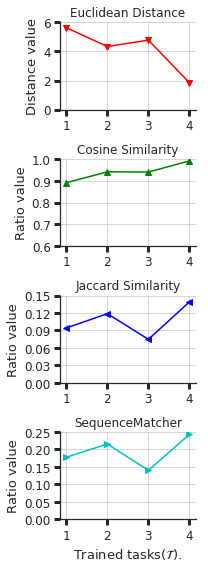

In [25]:
#Heuristic metric: Weights Pattern after training each task
from math import*
#1. Euclidean distance
def euclidean_distance(x,y):
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

#2. Cosine Similarity
def square_rooted(x):
    return round(sqrt(sum([a*a for a in x])),3)
def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return round(numerator/float(denominator),3)

#3. Jaccard similarity
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

#4. Using SequenceMatcher    
from difflib import SequenceMatcher

print("--------------Euclidean distance--------------------")
Eu_distance = []
for i in range(1,n_tasks):
    eu_dist = euclidean_distance(list(flatten(model_weights_save[i-1])),list(flatten(model_weights_save[i])))
    Eu_distance.append(eu_dist)
    print("Between task {0} and {1} : {2}".format(i-1,i,eu_dist))

print("--------------Cosine distance--------------------")
Cos_distance = []
for i in range(1,n_tasks):
    cos_dist = cosine_similarity(list(flatten(model_weights_save[i-1])),list(flatten(model_weights_save[i])))
    Cos_distance.append(cos_dist)
    print("Between task {0} and {1} : {2}".format(i-1,i,cos_dist))
    
    
print("--------------Jaccard similarity--------------------")
Jac_distance = []
for i in range(1,n_tasks):
    jac_dist = jaccard_similarity(list(flatten(model_weights_save[i-1])),list(flatten(model_weights_save[i])))
    Jac_distance.append(jac_dist)
    print("Between task {0} and {1} : {2}".format(i-1,i,jac_dist))

print("--------------Sequence Matcher--------------------")
Seq_matcher = []
for i in range(1,n_tasks):
    seq_matcher = SequenceMatcher(None,list(flatten(model_weights_save[i-1])),list(flatten(model_weights_save[i]))).ratio()
    Seq_matcher.append(seq_matcher)
    print("Between task {0} and {1} : {2}".format(i-1,i,seq_matcher))
    
import pdb
figure(figsize=(3, 8))
subplots_adjust(hspace=0.25,
                    wspace=0.35)
axs = [plt.subplot(4,1,1)]#, None, None]
for i in range(1, 4):
    axs.append(subplot(4, 1, i+1, sharex=axs[0]))
fontsize = 13

colorVal = ['r','g','b','c','m','k','y']
marker=["v","^","<",">","*","s"]

plots = [Eu_distance,Cos_distance,Jac_distance,Seq_matcher]
ylabel = ['Distance value', 'Ratio value', 'Ratio value','Ratio value']
ytick = [[0, 2, 4, 6], [0.6,0.7, 0.8, 0.9, 1],[0, 0.03, 0.06, 0.09, 0.12, 0.15], [0, 0.05, 0.1, 0.15, 0.2, 0.25]]
title = ['Euclidean Distance', 'Cosine Similarity', 'Jaccard Similarity', 'SequenceMatcher']
for i in range(4):
    axs[i].plot(range(1,n_tasks), plots[i], marker=marker[i], c=colorVal[i])
    axs[i].set_ylabel(ylabel[i],fontsize=fontsize)
    axs[i].set_yticks(ytick[i])
    axs[i].tick_params(labelsize='large', width=3)
    axs[i].grid()
    axs[i].set_title(title[i])
axs[-1].set_xticks(range(1,n_tasks))
axs[-1].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
plt.tight_layout()
sns.despine()
plt.savefig('MNIST_SI_Similaritymetric.pdf',bbox_inches = "tight")

In [15]:
len(model_weights_save)

5

In [16]:
#Heuristic metric: Weights Pattern between task 0 and last task 
from math import*
#1. Euclidean distance
def euclidean_distance(x,y):
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

#2. Cosine Similarity
def square_rooted(x):
    return round(sqrt(sum([a*a for a in x])),3)
def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return round(numerator/float(denominator),3)

#3. Jaccard similarity
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

#4. Using SequenceMatcher    
from difflib import SequenceMatcher


eu_dist = euclidean_distance(list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1])))
print("Euclidean distance between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,eu_dist))

cos_dist = cosine_similarity(list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1])))
print("Cosine angle between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,cos_dist))

jac_dist = jaccard_similarity(list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1])))
print("Jaccard similarity between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,jac_dist))

seq_matcher = SequenceMatcher(None,list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1]))).ratio()
print("Sequence angle between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,seq_matcher))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


Euclidean distance between task 0 and 4 : 8.932221840775831
Cosine angle between task 0 and 4 : 0.772
Jaccard similarity between task 0 and 4 : 0.05161453346100649
Sequence angle between task 0 and 4 : 0.09705734406438632


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


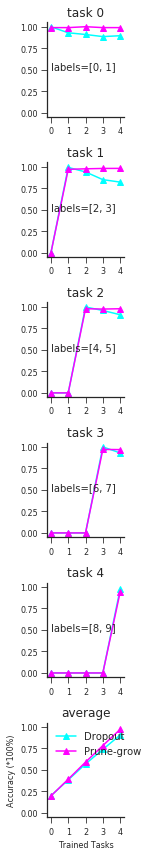

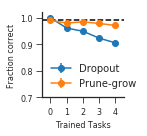

In [37]:
#Dropout vs prune-grow
data = {'mean': {0: array([[0.99952719, 0.        , 0.        , 0.        , 0.        ],
       [0.92952719, 0.99216454, 0.        , 0.        , 0.        ],
       [0.90952719, 0.93971596, 0.99786553, 0.        , 0.        ],
       [0.8852719, 0.85020568, 0.95679829, 0.99899295, 0.        ],
       [0.8952719, 0.82167483, 0.90786553, 0.92899295, 0.97226425]]), 
1.0: array([[0.98952719, 0.        , 0.        , 0.        , 0.        ],
       [0.98952719, 0.97020568, 0.        , 0.        , 0.        ],
       [1.        , 0.97579824, 0.97733191, 0.        , 0.        ],
       [0.98952719, 0.98020568, 0.97345784, 0.9697885, 0.        ],
       [0.98952719, 0.98090108, 0.97719317, 0.96748238, 0.93847705]])}, 'std': {0: array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]]), 1.0: array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])}}

figure(figsize=(2, 12))
axs = [subplot(n_tasks+1,1,1)]#, None, None]
for i in range(1, n_tasks + 1):
    axs.append(subplot(n_tasks+1,1, i+1, sharex=axs[0], sharey=axs[0]))
    
keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        colorVal = scalarMap.to_rgba(np.log(cval))
        # axs[j].plot(evals[:, j], c=colorVal)
        axs[j].errorbar(range(n_tasks), mean_vals[:, j], yerr=std_vals[:, j]/np.sqrt(n_stats), c=colorVal, marker='^')
    label = ['Dropout','Prune-grow']
    average = mean_vals.mean(1)  #Taking the average of cross validation accuracies accross all tasks after learning each task
    axs[-1].plot(average, c=colorVal, label=label[int(cval)],marker='^')
    axs[-1].set_xticks(np.arange(0, n_tasks, step=1))
    axs[-1].set_xlabel('Trained Tasks')
    axs[-1].set_ylabel('Accuracy (*100%)')

plt_tasklabel = task_labels[:]
plt_tasklabel.append('')
for i, ax in enumerate(axs):
    ax.legend(loc='upper left')
    ax.set_title((['task %d'%j for j in range(n_tasks)] + ['average'])[i])
    ax.text(0,0.5,('labels='+str(plt_tasklabel[i]))) if (i < len(task_labels)) else  ax.text(0,0.5,(plt_tasklabel[i]))

gcf().tight_layout()
sns.despine()
plt.savefig('Prune-Dropout-MNIST.pdf',bbox_inches='tight')

plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

fig = plt.figure(figsize=(2,2))
ax = plt.subplot(111)
ax.set_xticks(np.arange(0, n_tasks, step=1))

for cval in sorted_keys:
    mean_stuff = []
    std_stuff = []
    for i in range(len(data['mean'][cval])):
        mean_stuff.append(data['mean'][cval][i][:i+1].mean())
        std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
    # plot(range(1,n_tasks+1), mean_stuff, 'o-', label="c=%g"%cval)
    errorbar(range(0,n_tasks), mean_stuff, yerr=std_stuff, fmt='o-', label=label[int(cval)])
        
axhline(data['mean'][cval][0][0], linestyle='--', color='k')
xlabel('Trained Tasks')
ylabel('Fraction correct')
legend(loc='best')
xlim(-0.5, 4.5)
ylim(0.7, 1.02)
# grid('on')
# sns.despine()
simple_axis(ax)
gcf().tight_layout()
plt.savefig('Prune-Dropout-MNIST-fractionalcorrect.pdf')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


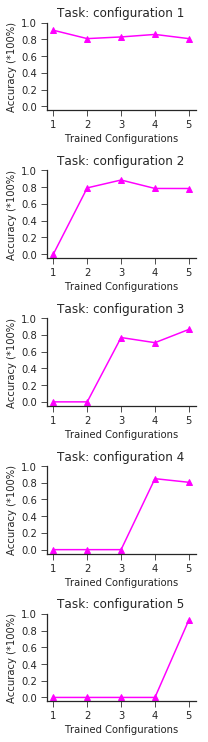

In [24]:
data={'mean': {1.0: array([[0.90952719, 0.50538688, 0.52401281, 0.48237664, 0.49117499],
       [0.80952719, 0.79167483, 0.52401281, 0.48237664, 0.49117499],
       [0.82952719, 0.88579824, 0.76946638, 0.48237664, 0.49117499],
       [0.85952719, 0.78481881, 0.70786553, 0.84899295, 0.49117499],
       [0.80952719, 0.78432909, 0.86626467, 0.80546828, 0.92478568]])}, 'std': {1.0: array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])}}

for k in cvals:
    for i in range(n_tasks):
        for j in range(i):
            data['mean'][k][j][i] = 0
            data['std'][k][j][i] = 0
        


figure(figsize=(3, 12))
axs = [subplot(n_tasks+1,1,1)]#, None, None]
for i in range(1, n_tasks):
    axs.append(subplot(n_tasks+1,1, i+1, sharex=axs[0], sharey=axs[0]))
    
keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        colorVal = scalarMap.to_rgba(np.log(cval))
        # axs[j].plot(evals[:, j], c=colorVal)
        axs[j].errorbar(range(1,n_tasks+1), mean_vals[:, j], yerr=std_vals[:, j]/np.sqrt(n_stats), c=colorVal, marker='^')
    #label = "Prune-grow=%g"%cval
    #average = mean_vals.mean(1)  #Taking the average of cross validation accuracies accross all tasks after learning each task
    #axs[-1].plot(average, c=colorVal, label=label,marker='^')
    axs[-1].set_xticks(np.arange(1, n_tasks+1, step=1))
    

plt_tasklabel = task_labels[:]
plt_tasklabel.append('')
for i, ax in enumerate(axs):
    ax.legend(loc='upper left')
    ax.set_title((['Task: configuration %d'%j for j in range(1,n_tasks+1)] + ['average'])[i])
    #ax.text(0,0.5,('labels='+str(plt_tasklabel[i]))) if (i < len(task_labels)) else  ax.text(0,0.5,(plt_tasklabel[i]))
    ax.set_xlabel('Trained Configurations')
    ax.set_ylabel('Accuracy (*100%)')
    ax.set_yticks(np.arange(0, 1.2, step=0.2))

plt.tight_layout()
sns.despine()
plt.savefig('Evolutionary_5tasks.pdf')

In [40]:
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [19]:
print(mean_vals,average); print(type(mean_vals))

[[0.99952719 0.47894221 0.45090715 0.63645519 0.62783661 0.51082474
  0.79326695 0.7        0.43949045 0.72916667]
 [0.99952719 0.97747307 0.45090715 0.63645519 0.62783661 0.51082474
  0.79326695 0.97437186 0.83341499 0.72916667]
 [0.99952719 0.97747307 0.9941302  0.63645519 0.62783661 0.67731959
  0.79326695 0.97437186 0.83341499 0.98020833]
 [0.99952719 0.97747307 0.9941302  0.99748238 0.62783661 0.9128866
  0.79326695 0.97437186 0.83341499 0.9421875 ]
 [0.99952719 0.97747307 0.9941302  0.99748238 0.9813414  0.9128866
  0.8610716  0.97437186 0.95051445 0.9421875 ]
 [0.99952719 0.97747307 0.99306297 0.99748238 0.9813414  0.98247423
  0.8610716  0.97437186 0.95051445 0.9421875 ]
 [0.99952719 0.97747307 0.99306297 0.99748238 0.98335855 0.98247423
  0.96823139 0.97437186 0.95051445 0.9421875 ]
 [0.99952719 0.97894221 0.99306297 0.99748238 0.98335855 0.98247423
  0.96823139 0.99095477 0.95051445 0.9421875 ]
 [0.99952719 0.98041136 0.99306297 0.99748238 0.9813414  0.98247423
  0.96823139 0

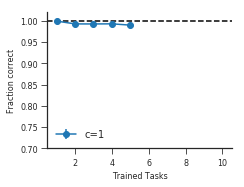

In [41]:
fig = plt.figure(figsize=(3.3,2.5))
ax = plt.subplot(111)

for cval in sorted_keys:
    mean_stuff = []
    std_stuff = []
    for i in range(len(data['mean'][cval])):
        mean_stuff.append(data['mean'][cval][i][:i+1].mean())
        std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
    # plot(range(1,n_tasks+1), mean_stuff, 'o-', label="c=%g"%cval)
    errorbar(range(1,n_tasks+1), mean_stuff, yerr=std_stuff, fmt='o-', label="c=%g"%cval)
        
axhline(data['mean'][cval][0][0], linestyle='--', color='k')
xlabel('Trained Tasks')
ylabel('Fraction correct')
legend(loc='best')
xlim(0.5, 10.5)
ylim(0.7, 1.02)
# grid('on')
# sns.despine()
simple_axis(ax)
plt.savefig('MNIST_Accuracy_10task_fractional_correctness.pdf')

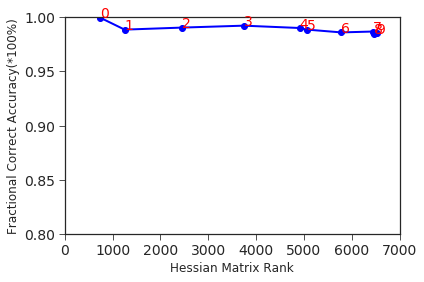

[0.9995271867612293, 0.9885001261915842, 0.9903768183859939, 0.9921532079486092, 0.9899908467421451, 0.9885602041092874, 0.9859442513826464, 0.9867542101802615, 0.9848987032621572, 0.9849492211429853]


In [27]:
import matplotlib     
matplotlib.rc('xtick', labelsize=14)     
matplotlib.rc('ytick', labelsize=14)
Hess_rank=[741, 1253, 2452, 3745, 4914, 5058, 5781, 6451, 6475, 6521] #calculated previously
plt.plot(Hess_rank,mean_stuff,'bo-', linewidth=2)
for i,j,k in zip(Hess_rank,mean_stuff,range(n_tasks)):
    plt.annotate(str(k),xy=(i,j),color='r', fontsize=14)
plt.xlabel('Hessian Matrix Rank',fontsize=12)
plt.ylabel('Fractional Correct Accuracy(*100%)',fontsize=12)
plt.yticks([1, 0.95, 0.90, 0.85, 0.80])
plt.xticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000])
plt.savefig('Fractioncorrect-Hessian-MNIST.pdf')
plt.show()
print(mean_stuff)

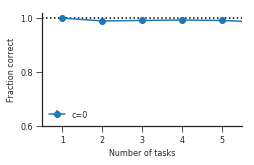

In [35]:
fig = plt.figure(figsize=(3.3,2.0))
ax = plt.subplot(111)

plot_keys =sorted(data['mean'].keys())# [0,1]

for cval in plot_keys:
    mean_stuff = []
    std_stuff = []
    for i in range(len(data['mean'][cval])):
        mean_stuff.append(data['mean'][cval][i][:i+1].mean())
        std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
    # plot(range(1,n_tasks+1), mean_stuff, 'o-', label="c=%g"%cval)
    errorbar(range(1,n_tasks+1), mean_stuff, yerr=std_stuff, fmt='o-', label="c=%g"%cval)
        
axhline(data['mean'][cval][0][0], linestyle=':', color='k')
xlabel('Number of tasks')
ylabel('Fraction correct')
legend(loc='best', fontsize=8)
xlim(0.5, 5.5)
plt.yticks([0.6,0.8,1.0])
ylim(0.6, 1.02)
# grid('on')
# sns.despine()
simple_axis(ax)
plt.subplots_adjust(left=.15, bottom=.18, right=.99, top=.97)
plt.savefig("split_mnist_accuracy.pdf")

In [21]:
len(model_weights_save),n_tasks # len(Flatten_weights), n_tasks
#Weights Pattern after training each task
import numpy as np
Flatten_weights=[]
#Flattening the weights into a list
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
for i in range(len(model_weights_save)):
    Flatten_weights.append(list(flatten(model_weights_save[i]))) 

weight_mean=[]
weight_std=[]
for i in range(len(Flatten_weights)):
    weight_mean.append(np.mean(np.absolute(Flatten_weights[i])))
    weight_std.append(np.std(np.absolute(Flatten_weights[i])))

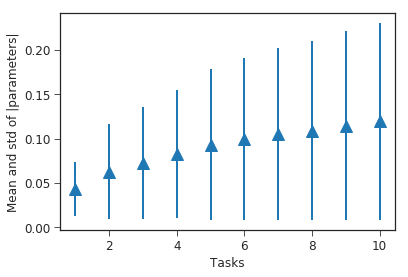

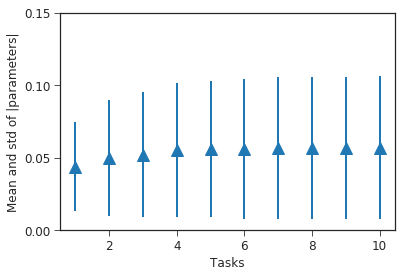

In [33]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 12})

x = range(1,len(weight_mean)+1)
y = weight_mean
e = weight_std

plt.errorbar(x[:10], y[:10], yerr=e[:10], linestyle='None', marker='^', linewidth=2, markersize=12)
plt.xlabel('Tasks'); plt.ylabel('Mean and std of |parameters|')

plt.show()

plt.errorbar(x[:10], y[10:], yerr=e[10:], linestyle='None', marker='^',linewidth=2, markersize=12)
plt.xlabel('Tasks'); plt.ylabel('Mean and std of |parameters|')
plt.yticks([0, 0.05, 0.10, 0.15])
plt.show()

In [20]:
#Weights Pattern after training each task
import numpy as np
Flatten_weights=[]
#Flattening the weights into a list
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
for i in range(len(model_weights_save)):
    Flatten_weights.append(list(flatten(model_weights_save[i]))) 

Extract_model_params = [];
#For model parameters without consolidation use val, with consolidation use val+100 
for i in range(n_tasks):
    Extract_model_params.append(Flatten_weights[i])
    
gradient_save=[]
for i in range(1,len(Extract_model_params)):
    temp=list(np.asarray(Extract_model_params[i-1])-np.asarray(Extract_model_params[i]))
    
    gradient = [j/0.001 for j in temp]
    gradient_save.append(gradient)

In [21]:
len(gradient_save)

9

In [22]:
import time
#Creating the Hessian matrix from the gradients
import math
Hessian_matrix = []
Hessian_row = []
start = time.time()
for k in range(len(gradient_save)):
    for i in range(len(gradient_save[k])):
        partial_deriv_1 = (math.ceil(gradient_save[k][i]*1e10)/1e10)
        for j in range(len(gradient_save[k])):
            partial_deriv_2 = (math.ceil(gradient_save[k][j]*1e10)/1e10)
            Hessian_row.append(np.around(partial_deriv_1*partial_deriv_2))
        Hessian_matrix.append(Hessian_row)
        Hessian_row = []
           
    print('Rank of the Hessian Matrix for k=',k,'is :',np.linalg.matrix_rank(np.asarray(Hessian_matrix)))
    end = time.time()
    print('Time to compute rank: '+ str(end - start))

Rank of the Hessian Matrix for k= 0 is : 1253
Time to compute rank: 445.1866958141327
Rank of the Hessian Matrix for k= 1 is : 1176
Time to compute rank: 894.114328622818


KeyboardInterrupt: 

In [ ]:
import pandas as pd
from numpy.linalg import matrix_rank
import math
corr_matrix = []
corr_row = []
for j in range(n_tasks):
    df = pd.DataFrame(training_datasets[j][0])
    correlation_matrix = df.corr().values
    correlation_matrix = np.nan_to_num(correlation_matrix)
    for k in range(len(correlation_matrix)):
        for i in range(len(correlation_matrix)):
            corr_elem = (math.ceil(correlation_matrix[k][i]*1e10)/1e10)
            corr_row.append(np.around(corr_elem))
        corr_matrix.append(corr_row)
        corr_row = []
    print('Rank of the Autocorrelation Matrix for task=',j,'is :',np.linalg.matrix_rank(np.asarray(corr_matrix)))

Rank of the Autocorrelation Matrix for task= 0 is : 558
Rank of the Autocorrelation Matrix for task= 1 is : 643


In [9]:
import pandas as pd
from numpy.linalg import matrix_rank
import math
corr_matrix = []
corr_row = []
for j in range(n_tasks):
    df = pd.DataFrame(training_datasets[j][0])
    correlation_matrix = df.corr().values
    correlation_matrix = np.nan_to_num(correlation_matrix)
    
    print('Rank of the Autocorrelation Matrix for task=',j,'is :',np.linalg.matrix_rank(np.asarray(correlation_matrix)))

Rank of the Autocorrelation Matrix for task= 0 is : 579
Rank of the Autocorrelation Matrix for task= 1 is : 637
Rank of the Autocorrelation Matrix for task= 2 is : 604
Rank of the Autocorrelation Matrix for task= 3 is : 667
Rank of the Autocorrelation Matrix for task= 4 is : 593
Rank of the Autocorrelation Matrix for task= 5 is : 618
Rank of the Autocorrelation Matrix for task= 6 is : 593
Rank of the Autocorrelation Matrix for task= 7 is : 607
Rank of the Autocorrelation Matrix for task= 8 is : 646
Rank of the Autocorrelation Matrix for task= 9 is : 634


In [14]:
import pdb
corr_matrix = []
corr_row = []
Rank_corr_matrix=[]
for j in range(1,n_tasks):
    for m in range(j):
        curr_task = training_datasets[j][0]
        prev_task = training_datasets[m][0]
        correlation_matrix = np.corrcoef(curr_task,prev_task)
        correlation_matrix = np.nan_to_num(correlation_matrix)
        '''
        for k in range(len(correlation_matrix)):
            for i in range(len(correlation_matrix)):
                corr_elem = (math.ceil(correlation_matrix[k][i]*1e10)/1e10)
                corr_row.append(np.around(corr_elem))
            corr_matrix.append(corr_row)
            corr_row = []
        '''
        #rank_corr_matrix=np.linalg.matrix_rank(np.asarray(correlation_matrix))
        #Rank_corr_matrix.append(rank_corr_matrix)
        print(correlation_matrix.shape)
        #print('Rank of the Cross-correlation Matrix of shape {0} between task {1} and {2} is: {3}'.format(correlation_matrix.shape,j,m,rank_corr_matrix))

> <ipython-input-14-36c34c1a7ab7>(10)<module>()
-> correlation_matrix = np.corrcoef(curr_task,prev_task)
(Pdb) curr_task.shape,prev_task.shape
((12089, 784), (12665, 784))
(Pdb) n
> <ipython-input-14-36c34c1a7ab7>(11)<module>()
-> correlation_matrix = np.nan_to_num(correlation_matrix)
(Pdb) correlation_matrix.shape
(24754, 24754)
(Pdb) type(curr_task), type(prev_task)
(<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)
(Pdb) q


BdbQuit: 

In [ ]:
from scipy import signal
corr = signal.correlate2d(training_datasets[1][0], training_datasets[0][0], boundary='symm', mode='same')
corr.shape

In [26]:
#Weights Pattern after training each task
Flatten_weights=[]
#Flattening the weights into a list
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
for i in range(len(model_weights_save)):
    Flatten_weights.append(list(flatten(model_weights_save[i]))) 

Extract_model_params = [];
#For model parameters without consolidation use val, with consolidation use val+50 
for i in range(n_tasks):   
    Extract_model_params.append(Flatten_weights[i])
    
#Weights Pattern after training each task
from math import*
#1. Euclidean distance
def euclidean_distance(x,y):
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))
#2. Manhattan Distance
def manhattan_distance(x,y):
    return sum(abs(a-b) for a,b in zip(x,y))
#3.  Minkowski distance 
from decimal import Decimal
def nth_root(value, n_root):
    root_value = 1/float(n_root)
    return round (Decimal(value) ** Decimal(root_value),3)
def minkowski_distance(x,y,p_value):
    return nth_root(sum(pow(abs(a-b),p_value) for a,b in zip(x, y)),p_value)
#4. Cosine Similarity
def square_rooted(x):
    return round(sqrt(sum([a*a for a in x])),3)
def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return round(numerator/float(denominator),3)
#5. Jaccard similarity
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)
#6. Using Heuristic    
import difflib 

for i in range(n_tasks-1):
    start = time.time()
    print("Eucledian Parameter shift after task {0} :".format(i+1),euclidean_distance(Extract_model_params[i],Extract_model_params[i+1]))
    end = time.time()
    print(end-start)
for i in range(n_tasks-1):
    start = time.time()
    print("Cosine Parameter shift after task {0} :".format(i+1),cosine_similarity(Extract_model_params[i],Extract_model_params[i+1]))
    end = time.time()
    print(end-start)
for i in range(n_tasks-1):
    start = time.time()
    print("Jaccard Parameter shift after task {0} :".format(i+1),jaccard_similarity(Extract_model_params[i],Extract_model_params[i+1]))
    end = time.time()
    print(end-start)
for i in range(n_tasks-1):
    start = time.time()
    print("Heuristic Parameter shift after task {0} :".format(i+1),difflib.SequenceMatcher(None,Extract_model_params[i],Extract_model_params[i+1]).ratio())
    end = time.time()
    print(end-start)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


Eucledian Parameter shift after task 1 : 5.62173140970746
0.0026137828826904297
Eucledian Parameter shift after task 2 : 5.4647902230104455
0.002468585968017578
Eucledian Parameter shift after task 3 : 5.2624894699297675
0.002474546432495117
Eucledian Parameter shift after task 4 : 6.158105342597548
0.0024728775024414062
Eucledian Parameter shift after task 5 : 4.018116457906755
0.002460002899169922
Eucledian Parameter shift after task 6 : 3.116287827931274
0.002474546432495117
Eucledian Parameter shift after task 7 : 1.9178605216601121
0.0024726390838623047
Eucledian Parameter shift after task 8 : 2.71614015494838
0.002460002899169922
Eucledian Parameter shift after task 9 : 3.232597255499332
0.002476215362548828
Cosine Parameter shift after task 1 : 0.679
0.004570484161376953
Cosine Parameter shift after task 2 : 0.812
0.004438161849975586
Cosine Parameter shift after task 3 : 0.872
0.004423856735229492
Cosine Parameter shift after task 4 : 0.867
0.004453420639038086
Cosine Parameter

In [48]:
#Saving the parameters for future use
import pickle
with open("MNIST_Parameters.txt", "wb") as fp:   #Pickling
    pickle.dump(model_weights_save, fp)

In [1]:
import pickle
with open("MNIST_Parameters.txt", "rb") as fp:   # Unpickling
    model_weights_save = pickle.load(fp)

In [3]:
len(model_weights_save[0])

4

In [ ]:
#Creating the Hessian matrix from the gradients
import math
Hessian_matrix = []
Hessian_row = []

for i in range(len(gradient_save[0])):
    partial_deriv_1 = (math.ceil(gradient_save[0][i]*1e10)/1e10)
    for j in range(len(gradient_save[k])):
        partial_deriv_2 = (math.ceil(gradient_save[0][j]*1e10)/1e10)
        Hessian_row.append(np.around(partial_deriv_1*partial_deriv_2))
    Hessian_matrix.append(Hessian_row)
    print(i)
    Hessian_row = []
print('Counter')
#print('Rank of the Hessian Matrix for k=',k,'is :',np.linalg.matrix_rank(np.asarray(Hessian_matrix)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [63]:
from numpy.linalg import matrix_rank

n_layers = 3
for j in range(n_tasks):
    for i in range(n_layers):
        weight_matrix = np.matrix(model_weights_save[j][2*i], dtype='float')
        
        print('Dimension of {0}-layer Weight matrix of shape-{1} for task-{2} is: {3}'.format(i+1,weight_matrix.shape,j,matrix_rank(weight_matrix)))
    print('Dimension of data for task-{0} of shape-{1} is: {2}'.format(j,training_datasets[j][0].shape,matrix_rank(np.matrix(training_datasets[j][0], dtype='float'))))
    print('----------------------------------------------------------------------')

Dimension of 1-layer Weight matrix of shape-(784, 256) for task-0 is: 256
Dimension of 2-layer Weight matrix of shape-(256, 256) for task-0 is: 256
Dimension of 3-layer Weight matrix of shape-(256, 10) for task-0 is: 2
Dimension of data for task-0 of shape-(12665, 784) is: 579
----------------------------------------------------------------------
Dimension of 1-layer Weight matrix of shape-(784, 256) for task-1 is: 256
Dimension of 2-layer Weight matrix of shape-(256, 256) for task-1 is: 256
Dimension of 3-layer Weight matrix of shape-(256, 10) for task-1 is: 4
Dimension of data for task-1 of shape-(12089, 784) is: 637
----------------------------------------------------------------------
Dimension of 1-layer Weight matrix of shape-(784, 256) for task-2 is: 256
Dimension of 2-layer Weight matrix of shape-(256, 256) for task-2 is: 256
Dimension of 3-layer Weight matrix of shape-(256, 10) for task-2 is: 6
Dimension of data for task-2 of shape-(11263, 784) is: 604
------------------------

In [21]:
#https://github.com/OFAI/hub-toolbox-python3/blob/master/hub_toolbox/IntrinsicDim.py
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
This file is part of the HUB TOOLBOX available at
http://ofai.at/research/impml/projects/hubology.html
Source code is available at
https://github.com/OFAI/hub-toolbox-python3/
The HUB TOOLBOX is licensed under the terms of the GNU GPLv3.
(c) 2011-2016, Dominik Schnitzer and Roman Feldbauer
Austrian Research Institute for Artificial Intelligence (OFAI)
Contact: <roman.feldbauer@ofai.at>
This file is based on a Matlab script by Elizaveta Levina, University of 
Michigan, available at http://dept.stat.lsa.umich.edu/~elevina/mledim.m
Reference:  E. Levina and P.J. Bickel (2005).  
 "Maximum Likelihood Estimation  of Intrinsic Dimension."  
 In Advances in NIPS 17, Eds. L. K. Saul, Y. Weiss, L. Bottou. 
"""
import sys
import numpy as np
import pdb

def intrinsic_dimension(X:np.ndarray, k1:int=6, k2:int=12, 
                        estimator:str='levina', metric:str='vector', 
                        trafo:str='var', mem_threshold:int=5000):
    """Calculate intrinsic dimension based on the MLE by Levina and Bickel [1]_.
    
    Parameters
    ----------
    X : ndarray
        - An ``m x n`` vector data matrix with ``n`` objects in an 
          ``m`` dimensional feature space 
        - An ``n x n`` distance matrix.
        
        NOTE: The type must be defined via parameter `metric`!
        
    k1 : int, optional (default: 6)
        Start of neighborhood range to search in.
        
    k2 : int, optional (default: 12)
        End of neighborhood range to search in.
        
    estimator : {'levina', 'mackay'}, optional (default: 'levina')
        Determine the summation strategy: see [2]_.
    
    metric : {'vector', 'distance'}, optional (default: 'vector')
        Determine data type of `X`. 
        
        NOTE: the MLE was derived for euclidean distances. Using 
        other dissimilarity measures may lead to undefined results.
        
    trafo : {None, 'std', 'var'}, optional (default: 'var')
        Transform vector data. 
        
        - None: no transformation
        - 'std': standardization 
        - 'var': subtract mean, divide by variance (default behavior of 
          Laurens van der Maaten's DR toolbox; most likely for other 
          ID/DR techniques).
    mem_treshold : int, optional, default: 5000
        Controls speed-memory usage trade-off: If number of points is higher
        than the given value, don't calculate complete distance matrix at
        once (fast, high memory), but per row (slower, less memory).
    Returns
    -------
    d_mle : int
        Intrinsic dimension estimate (rounded to next integer)
    
    References
    ----------
    .. [1] Levina, E., & Bickel, P. (2004). Maximum likelihood estimation of 
           intrinsic dimension. Advances in Neural Information …, 17, 777–784. 
           http://doi.org/10.2307/2335172
    .. [2] http://www.inference.phy.cam.ac.uk/mackay/dimension/
    """
    n = X.shape[0]
    if estimator not in ['levina', 'mackay']:
        raise ValueError("Parameter 'estimator' must be 'levina' or 'mackay'.")
    if k1 < 1 or k2 < k1 or k2 >= n:
        raise ValueError("Invalid neighborhood: Please make sure that "
                         "0 < k1 <= k2 < n. (Got k1={} and k2={}).".
                         format(k1, k2))
    X = X.copy().astype(float)
        
    if metric == 'vector':
        # New array with unique rows   
        X = X[np.lexsort(np.fliplr(X).T)]
        
        if trafo is None:
            pass
        elif trafo == 'var':
            X -= X.mean(axis=0) # broadcast
            X /= X.var(axis=0) + 1e-7 # broadcast
        elif trafo == 'std':
            # Standardization
            X -= X.mean(axis=0) # broadcast
            X /= X.std(axis=0) + 1e-7 # broadcast
        else:
            raise ValueError("Transformation must be None, 'std', or 'var'.")
        
        # Compute matrix of log nearest neighbor distances
        X2 = (X**2).sum(1)
        
        
        distance = X2.reshape(-1, 1) + X2 - 2*np.dot(X, X.T) #2x br.cast
        distance.sort(1)
        # Replace invalid values with a small number
        distance[distance<=0] = 1e-7
        
        try:
            knnmatrix = .5 * np.log(distance[:, 1:k2+1])
        except:
            print('log caluclation error')
        
    
    elif metric == 'distance':
        raise NotImplementedError("ID currently only supports vector data.")
        #=======================================================================
        # # TODO calculation WRONG
        # X.sort(1)
        # X[X < 0] = 1e-7
        # knnmatrix = np.log(X[:, 1:k2+1])
        #=======================================================================
    elif metric == 'similarity':
        raise NotImplementedError("ID currently only supports vector data.")
        #=======================================================================
        # # TODO calculation WRONG
        # print("WARNING: using similarity data may return "
        #       "undefined results.", file=sys.stderr)
        # X[X < 0] = 0
        # distance = 1 - (X / X.max())
        # knnmatrix = np.log(distance[:, 1:k2+1])
        #=======================================================================
    else:
        raise ValueError("Parameter 'metric' must be 'vector' or 'distance'.")
    
    # Compute the ML estimate
    S = np.cumsum(knnmatrix, 1)
    indexk = np.arange(k1, k2+1) # broadcasted afterwards
    try:
        dividor = S[:, k1-1:k2] - knnmatrix[:, k1-1:k2] * indexk
        dhat = -(indexk - 2) / dividor
        dhat[dhat < -n] = 0
        dhat[dhat > n] = 0
    except:
        print('dhat calculation error')
    
    if estimator == 'levina':  
        # Average over estimates and over values of k
        no_dims = dhat.mean()
    if estimator == 'mackay':
        # Average over inverses
        dhat **= -1
        dhat_k = dhat.mean(0)
        no_dims = (dhat_k ** -1).mean()       
    no_dims = np.nan_to_num(no_dims)
    return int(no_dims.round())
    

class IntrinsicDim(): # pragma: no cover
    """
    .. note:: Deprecated in hub-toolbox 2.3
              Class will be removed in hub-toolbox 3.0.
              Please use static functions instead.
    """
       
    def __init__(self, X, data_type='vector'):
        """
        .. note:: Deprecated in hub-toolbox 2.3
                  Class will be removed in hub-toolbox 3.0.
                  Please use static functions instead.
        """
        # Deep copy required due to changes in vector data
        self.X = X.copy()
        if data_type in ['vector', 'distance', 'similarity']:
            self.data_type = data_type
            if data_type != 'vector':
                raise NotImplementedError("IntrinsicDim currently only "
                                          "supports vector data.")
        else:
            raise ValueError("Parameter data_type must be 'vector', 'distance'"
                             " , or 'similarity'. Got '{}' instead.".
                             format(data_type.__str__())) 

    def calculate_intrinsic_dimensionality(self, k1=6, k2=12, 
                                           estimator='levina'):
        """
        .. note:: Deprecated in hub-toolbox 2.3
                  Class will be removed in hub-toolbox 3.0.
                  Please use static functions instead.
        """
        print("DEPRECATED: Please use IntrinsicDim.intrinsic_dimension().", 
              file=sys.stderr)
        return intrinsic_dimension(self.X, k1, k2, estimator, self.data_type)
    
if __name__ == '__main__':
    n_layers = 3
    for j in range(n_tasks):
        for i in range(n_layers):
            VECT_DATA = np.matrix(model_weights_save[j][2*i], dtype='float')
            id_ = intrinsic_dimension(np.array(VECT_DATA), trafo=None)

            print('Intrinsic dimension of {0}-layer Weight matrix of shape-{1} for task-{2} is: {3}'.format(i+1,VECT_DATA.shape,j,id_))
        
        print('----------------------------------------------------------------------')

Intrinsic dimension of 1-layer Weight matrix of shape-(784, 256) for task-0 is: 65
Intrinsic dimension of 2-layer Weight matrix of shape-(256, 256) for task-0 is: 57
Intrinsic dimension of 3-layer Weight matrix of shape-(256, 10) for task-0 is: 1
----------------------------------------------------------------------
Intrinsic dimension of 1-layer Weight matrix of shape-(784, 256) for task-1 is: 51
Intrinsic dimension of 2-layer Weight matrix of shape-(256, 256) for task-1 is: 55
Intrinsic dimension of 3-layer Weight matrix of shape-(256, 10) for task-1 is: 2
----------------------------------------------------------------------
Intrinsic dimension of 1-layer Weight matrix of shape-(784, 256) for task-2 is: 49
Intrinsic dimension of 2-layer Weight matrix of shape-(256, 256) for task-2 is: 55
Intrinsic dimension of 3-layer Weight matrix of shape-(256, 10) for task-2 is: 2
----------------------------------------------------------------------
Intrinsic dimension of 1-layer Weight matrix o